## Optimal Growth Temperature (OGT): phenotype prediction, feature selection, and data visualization

This notebook provides a pipeline for predicting the optimal growth temperature (OGT) and identifying genome footprints.

We train and test XGBoost regression on COG count tables, that are split into the test and train ones at a specified taxonomy level (i.e. all samples from a taxonomy group go to either train or test). The notebook can be run for one taxonomy level split.

To identify genome footprints and the most important features (COGs) contributing to the phenotype prediction, we use three different feature selection ranking methods:

- calculating the mutual information between the feature and the target label vector,
- using the feature weights returned by the random forest model,
- calculating SHAP values using the pre-trained XGBoost model.

The predictions of those three methods are compared between each other at the end of the notebook.

#### 1. Read the train and test datasets

First, we read the input files generated by *taxa_level_split.py*. The script generates 6 output files for the chosen [tax_level] of the train/test split, that are used as main inputs in this notebook. The files are the following:

- train_data_[tax_level]_tax_level : training count table,
- train_annot_[tax_level]_tax_level : training annotations,
- train_taxa_names_[tax_level]_tax_level : [tax_level] name of each training sample,

\+ 3 similar test tables. Those files should be stored in the corresponding directory for the phenotype.

In order to run the phenotype prediction pipeline in this notebook, the data directory with the input files, and [tax_level] of the train/test split should be specified below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "family" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 2513, number of features = 3165
Number of samples = 642, number of features = 3165


In [3]:
# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)

Before we train and validate XGBoost on the generated data, we check the distribution of OGTs in the train and test datasets. Ideally, these distributions should be similar and representative (i.e. no missing temperature ranges) to keep both training and validation fair. 

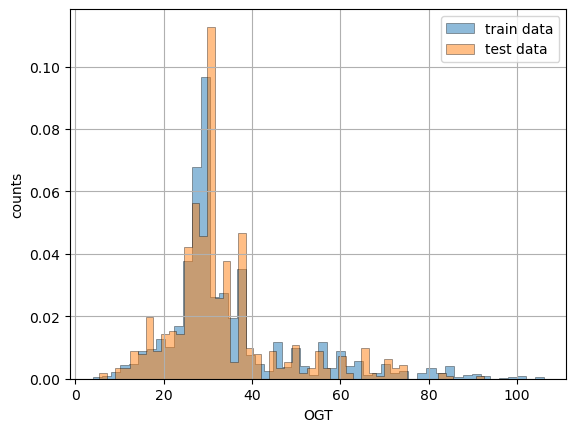

In [12]:
hist = plt.hist(y_train.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();
plt.savefig(f"{OUTPUT_DIRECTORY}/train_test_data_distr.pdf", format="pdf")

#### 2. PCA and tSNE projections of the training data (colors = temperature)

In this section, we visualize all points from our datasets by projecting them into 2D PCA, and tSNE spaces. This projections give us insights on the structure of the datasets. 

First, we visualize the points and color them with respect to their OGTs.

Shape of the projected data = (2513, 2)


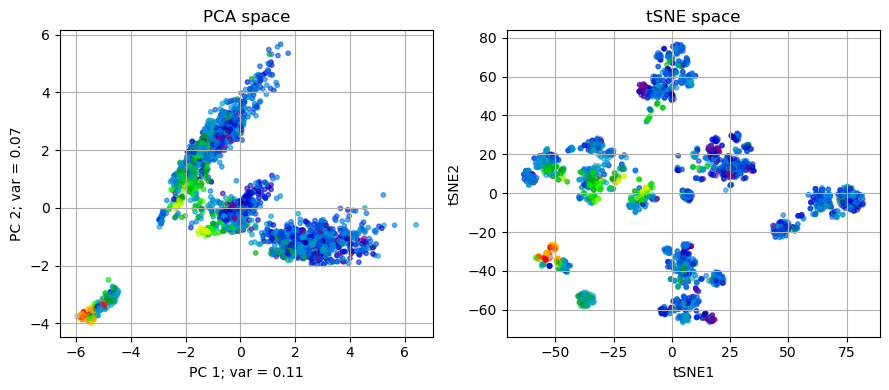

In [16]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_orig_phenot.pdf", format="pdf")
plt.show()

Next, we color the point with respect to the taxonomic level we chose for the train/test data split.

Shape of the projected data = (2513, 2)


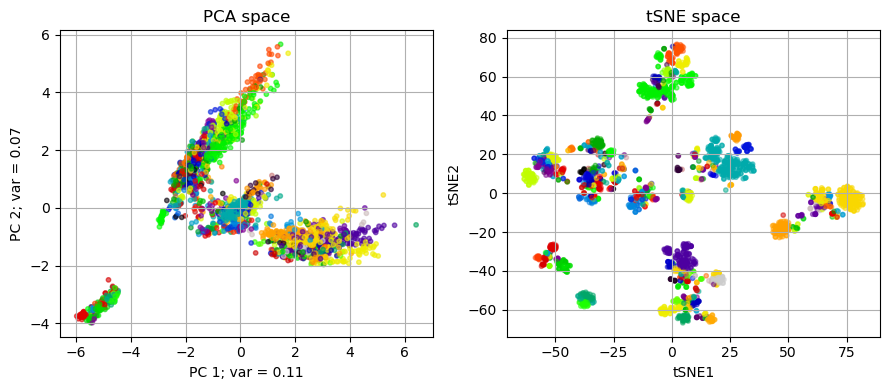

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
colors = None
category_names = taxa_group_names_train
pca_run_and_plot(X_train, n_compon, label_encoder.fit_transform(category_names),
                 category_names, colors);
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, label_encoder.fit_transform(category_names));

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_all_feat.pdf", format="pdf")
plt.show()

#### 3. XGBoost training and feature selection


In this section, we find the baseline XGBoost accuracy measures using the entire initial feature set (e.g. all COGs). For OGT, we use RMSE and R2 calculated for the predicted and actual OGTs.

In [14]:
from utils.utils import train_xgboost
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train, X_test.cpu(), y_test) 

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 6.72, R2 = 0.74
XGBoost baseline CV RMSE (all features) = 6.12, R2 = 0.85


The visualisation of the predictions collected during cross-validation and test predictions is shown below. In addition, the discrepancy between the actual and predicted OGTs is shown. As we can see, the lower range temperatures are persistently overestimeted. 

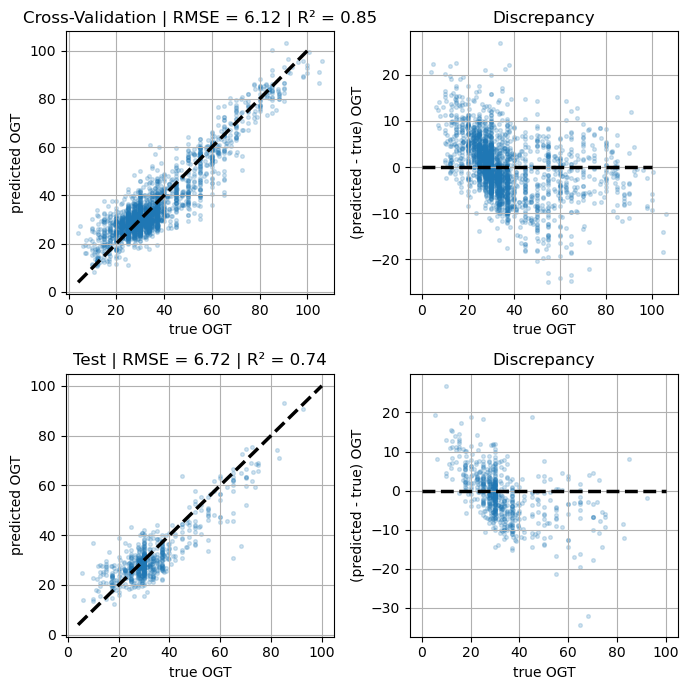

In [15]:
plt.figure(figsize=(7, 7))

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

plt.subplot(2, 2, 3) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 4) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

#### 4. XGBoost classifier


In [7]:
import torch

def convert_to_classes(y_train, y_test, N):
    # Concatenate and flatten
    y_all = torch.cat((y_train, y_test)).view(-1)

    # Get min and max
    y_min, y_max = y_all.min().item(), y_all.max().item()

    # Define bin edges
    bins = torch.linspace(y_min, y_max, N + 1)

    # Create class ranges dictionary
    class_ranges = {i: [bins[i].item(), bins[i+1].item()] for i in range(N)}

    # Digitize function (torch doesn't have this natively, use searchsorted)
    def digitize(y):
        return torch.bucketize(y.view(-1), bins[:-1], right=False)

    # Convert values to class indices
    y_train_cls = digitize(y_train)
    y_test_cls = digitize(y_test) - 1

    return y_train_cls, y_test_cls, class_ranges


In [8]:
# Data categorization
num_classes = 32
y_train_cls, y_test_cls, class_ranges = convert_to_classes(y_train, y_test, num_classes)

In [9]:
N = num_classes
y_all = torch.cat((y_train, y_test)).view(-1)
y_min, y_max = y_all.min().item(), y_all.max().item()
bins = torch.linspace(y_min, y_max, N+1)
class_ranges = {i: [bins[i].item(), bins[i+1].item()] for i in range(N)}

def digitize(y):
    return torch.bucketize(y.view(-1), bins[1:], right=False)

# Convert values to class indices
y_train_cls = digitize(y_train) 
y_test_cls = digitize(y_test)
print(bins)
print(max(y_train))
max(y_train_cls)

tensor([  4.0000,   7.1875,  10.3750,  13.5625,  16.7500,  19.9375,  23.1250,
         26.3125,  29.5000,  32.6875,  35.8750,  39.0625,  42.2500,  45.4375,
         48.6250,  51.8125,  55.0000,  58.1875,  61.3750,  64.5625,  67.7500,
         70.9375,  74.1250,  77.3125,  80.5000,  83.6875,  86.8750,  90.0625,
         93.2500,  96.4375,  99.6250, 102.8125, 106.0000])
tensor([106.])


tensor(31)

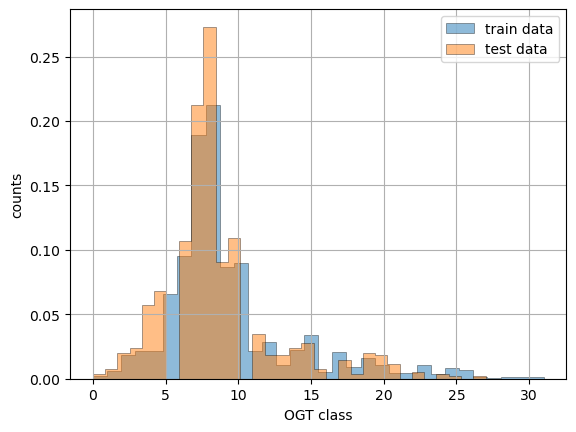

In [26]:
hist = plt.hist(y_train_cls, bins = num_classes, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test_cls, bins = num_classes, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT class")
plt.ylabel("counts")
plt.grid(True)
plt.legend();
#plt.savefig(f"{OUTPUT_DIRECTORY}/train_test_data_distr.pdf", format="pdf")

In [9]:
from utils.utils import train_xgboost_classification

y_true_cv, y_pred_cv, y_pred_test = train_xgboost_classification(X_train, y_train_cls, X_test, y_test_cls, num_classes=num_classes)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [10]:
from sklearn.metrics import mean_squared_error,r2_score

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 26.69, R2 = -3.18
XGBoost baseline CV RMSE (all features) = 2.30, R2 = 0.78


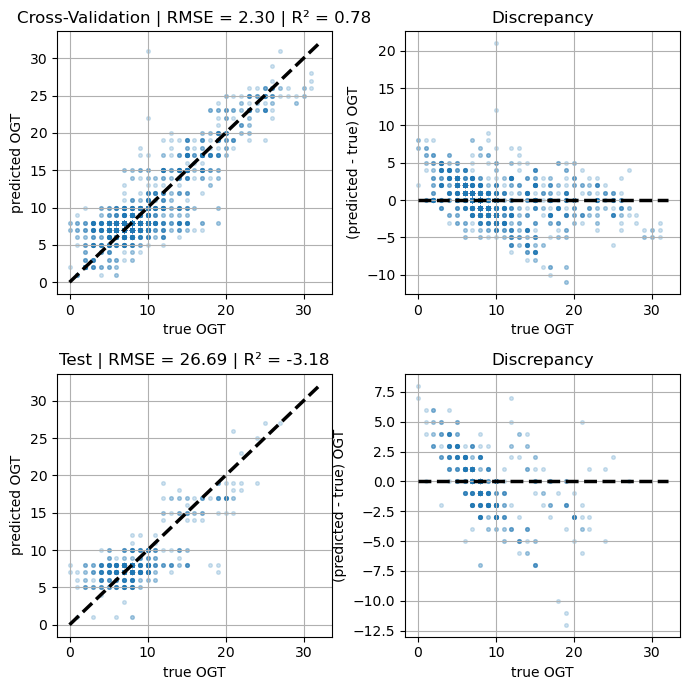

In [11]:
plt.figure(figsize=(7, 7))

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([0, num_classes],[0,num_classes], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,num_classes],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.scatter(y_test_cls, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([0, num_classes],[0, num_classes], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 4) 
diff = [y_pred_test[i] - y_test_cls[i] for i in range(len(y_pred_test))]
plt.scatter(y_test_cls, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,num_classes],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout() 

#### 4. SetTransformer training and feature selection


In [4]:
import sys
import os
from pathlib import Path

# Get the current file's directory
current_dir = Path.cwd()

# Add parent and grandparent to sys.path
parent_dir = current_dir.parent
grandparent_dir = parent_dir.parent

sys.path.append(str(parent_dir))
sys.path.append(str(grandparent_dir))

from set_transformer.set_transformer_architecture import SetTransformer

In [18]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

num_folds = 5

from sklearn.model_selection import GroupShuffleSplit

device = DEVICE
ogt_continuous_flag = True
num_epochs = 20
learning_rate = 1e-3

kfold = KFold(n_splits=num_folds, shuffle=True)#, random_state=42)
fold_train_test_ind = enumerate(kfold.split(X_train, y_train))
if ogt_continuous_flag == False:
    dim_output = num_classes
else:
    dim_output = 1    

D = X_train.shape[1]
K = 1

num_inds = 4
batch_size = 20

net = SetTransformer(D, K, dim_output, num_inds)
net = net.to(DEVICE)


In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error
import torch
import torch.optim as optim
import numpy as np

def train_set_transformer(X_train, y_train, X_test, y_test, num_inds=num_inds, num_classes=num_classes, ogt_continuous_flag=False, num_epochs=num_epochs, batch_size=batch_size):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    D = X_train.shape[1]
    K = 1
    dim_output = 1 if ogt_continuous_flag else num_classes

    def create_model():
        net = SetTransformer(D, K, dim_output, num_inds)
        return net.to(device)

    kf = KFold(n_splits=5, shuffle=True)
    y_true_list = []
    y_pred_list = []


    target_mean = y_train.mean()
    target_std = y_train.std()
    weights_np = np.abs((y_train - target_mean) / target_std)
    weights_tensor_all = torch.tensor(weights_np, dtype=torch.float32).to(device)

    plt.figure()
    hist = plt.hist(weights_tensor_all, bins = 30, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)

    


    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        print(f"\nFold {fold+1}/5")
        model = create_model()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
        criterion = torch.nn.MSELoss() if ogt_continuous_flag else torch.nn.CrossEntropyLoss()

        # Prepare data
        X_fold_train = torch.tensor(X_train[train_idx], dtype=torch.float32).to(device)
        y_fold_train = torch.tensor(y_train[train_idx], dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)
        X_fold_val = torch.tensor(X_train[val_idx], dtype=torch.float32).to(device)
        y_fold_val = torch.tensor(y_train[val_idx], dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)

       # train_loader = DataLoader(TensorDataset(X_fold_train, y_fold_train), batch_size=batch_size, shuffle=True)

        train_dataset = TensorDataset(X_fold_train, y_fold_train, torch.arange(len(y_fold_train)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        
        # Training loop
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for batch_data, batch_labels, batch_indices in train_loader:
            #for batch_data, batch_labels in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_data.unsqueeze(1)).squeeze()
                if ogt_continuous_flag and outputs.ndim == 1:
                    outputs = outputs.unsqueeze(1)

               # loss_raw = criterion(outputs, batch_labels.unsqueeze(1))
               # batch_weights = weights_tensor_all[batch_indices]
              #  loss = (loss_raw.squeeze() * batch_weights).mean()

                
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"CV epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            preds = model(X_fold_val.unsqueeze(1)).squeeze()
            if not ogt_continuous_flag:
                preds = torch.nn.functional.softmax(preds, dim=-1)
                pred_classes = torch.argmax(preds, dim=1)
                y_true_list.append(y_fold_val.cpu().numpy())
                y_pred_list.append(pred_classes.cpu().numpy())
            else:
                y_true_list.append(y_fold_val.cpu().numpy())
                y_pred_list.append(preds.cpu().numpy())

    y_true_cv = np.concatenate(y_true_list)
    y_pred_cv = np.concatenate(y_pred_list)

    # Final training on full train set
    model = create_model()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    criterion = torch.nn.MSELoss() if ogt_continuous_flag else torch.nn.CrossEntropyLoss()

    X_full_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_full_train = torch.tensor(y_train, dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)
    full_loader = DataLoader(TensorDataset(X_full_train, y_full_train), batch_size=batch_size, shuffle=True)

    model.train()


    
    # In training:
    weights = np.abs((y_train - y_train.mean()) / y_train.std())
    weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)

    print(weights_tensor)
    
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_data, batch_labels in full_loader:
            #print(f"batch_labels = {batch_labels}")
            optimizer.zero_grad()
            outputs = model(batch_data.unsqueeze(1)).squeeze()
            if ogt_continuous_flag and outputs.ndim == 1:
                outputs = outputs.unsqueeze(1)

            #loss_raw = criterion(outputs, batch_labels)
            #loss = (loss_raw * weights_tensor[batch_labels]).mean()
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Training epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")

    # Final prediction
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        test_outputs = model(X_test_tensor.unsqueeze(1)).squeeze()
        if not ogt_continuous_flag:
            test_outputs = torch.nn.functional.softmax(test_outputs, dim=-1)
            y_pred_test = torch.argmax(test_outputs, dim=1).cpu().numpy()
        else:
            y_pred_test = test_outputs.cpu().numpy()

    return y_true_cv, y_pred_cv, y_pred_test


In [44]:
target_mean = np.mean(y_train.squeeze().cpu().numpy())
target_mean

35.039852

/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_tensor_all = torch.tensor(weights_np, dtype=torch.float32).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_fold_train = torch.tensor(X_train[train_idx], dtype=torch.float32).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 


Fold 1/5


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


CV epoch 1/20, Loss: 333.4206
CV epoch 2/20, Loss: 181.3323
CV epoch 3/20, Loss: 175.3841
CV epoch 4/20, Loss: 177.7538
CV epoch 5/20, Loss: 179.0713
CV epoch 6/20, Loss: 182.4553
CV epoch 7/20, Loss: 178.4053
CV epoch 8/20, Loss: 176.8401
CV epoch 9/20, Loss: 179.8402
CV epoch 10/20, Loss: 175.8514
CV epoch 11/20, Loss: 179.6987
CV epoch 12/20, Loss: 180.2216
CV epoch 13/20, Loss: 181.6552
CV epoch 14/20, Loss: 178.3117
CV epoch 15/20, Loss: 178.8696
CV epoch 16/20, Loss: 178.9687
CV epoch 17/20, Loss: 179.2338
CV epoch 18/20, Loss: 181.1540
CV epoch 19/20, Loss: 176.8787
CV epoch 20/20, Loss: 175.9955

Fold 2/5
CV epoch 1/20, Loss: 311.2047
CV epoch 2/20, Loss: 178.1486
CV epoch 3/20, Loss: 171.7964
CV epoch 4/20, Loss: 170.3623
CV epoch 5/20, Loss: 171.3657
CV epoch 6/20, Loss: 171.1423
CV epoch 7/20, Loss: 171.8063
CV epoch 8/20, Loss: 173.1290
CV epoch 9/20, Loss: 170.8123
CV epoch 10/20, Loss: 171.7465
CV epoch 11/20, Loss: 170.1263
CV epoch 12/20, Loss: 177.1429
CV epoch 13/20, 

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([11, 1, 1])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


CV epoch 1/20, Loss: 334.6955
CV epoch 2/20, Loss: 185.0251
CV epoch 3/20, Loss: 171.7836
CV epoch 4/20, Loss: 172.6155
CV epoch 5/20, Loss: 169.1844
CV epoch 6/20, Loss: 168.3019
CV epoch 7/20, Loss: 169.5572
CV epoch 8/20, Loss: 173.4002
CV epoch 9/20, Loss: 171.8315
CV epoch 10/20, Loss: 171.4083
CV epoch 11/20, Loss: 171.8067
CV epoch 12/20, Loss: 168.5783
CV epoch 13/20, Loss: 170.4824
CV epoch 14/20, Loss: 172.3410
CV epoch 15/20, Loss: 170.8785
CV epoch 16/20, Loss: 171.1412
CV epoch 17/20, Loss: 171.8674
CV epoch 18/20, Loss: 174.5478
CV epoch 19/20, Loss: 172.8286
CV epoch 20/20, Loss: 168.1360

Fold 5/5
CV epoch 1/20, Loss: 348.5197
CV epoch 2/20, Loss: 183.5539
CV epoch 3/20, Loss: 173.0315
CV epoch 4/20, Loss: 176.3550
CV epoch 5/20, Loss: 174.6144
CV epoch 6/20, Loss: 175.0404
CV epoch 7/20, Loss: 174.6766
CV epoch 8/20, Loss: 172.2605
CV epoch 9/20, Loss: 177.1999
CV epoch 10/20, Loss: 176.9579
CV epoch 11/20, Loss: 175.9227
CV epoch 12/20, Loss: 173.5620
CV epoch 13/20, 

/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_full_train = torch.tensor(X_train, dtype=torch.float32).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_full_train = torch.tensor(y_train, dtype=torch.float32 if ogt_continuous_flag else torch.long).to(device)
/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

Training epoch 1/20, Loss: 529.3963
Training epoch 2/20, Loss: 309.5815
Training epoch 3/20, Loss: 203.9275
Training epoch 4/20, Loss: 111.3422
Training epoch 5/20, Loss: 81.2693
Training epoch 6/20, Loss: 58.1950
Training epoch 7/20, Loss: 47.2699
Training epoch 8/20, Loss: 43.1249
Training epoch 9/20, Loss: 35.9749
Training epoch 10/20, Loss: 35.4850
Training epoch 11/20, Loss: 32.5999
Training epoch 12/20, Loss: 30.0091
Training epoch 13/20, Loss: 29.9927
Training epoch 14/20, Loss: 26.8170
Training epoch 15/20, Loss: 23.5568
Training epoch 16/20, Loss: 24.3870
Training epoch 17/20, Loss: 24.6699
Training epoch 18/20, Loss: 22.0610
Training epoch 19/20, Loss: 22.2297
Training epoch 20/20, Loss: 22.8357


/var/folders/s5/5qyfbtgx7wdd9zg3q4zplgkc0000gn/T/ipykernel_70410/2399712245.py:132: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


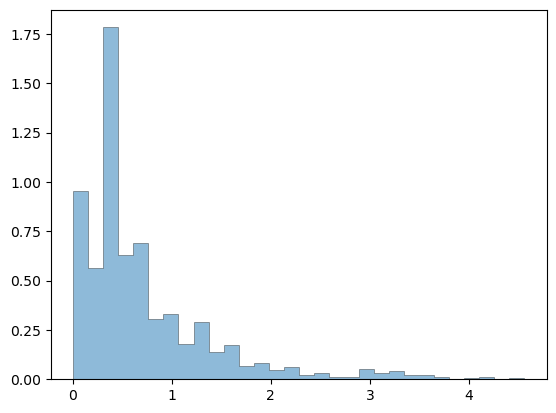

In [45]:
y_true_cv, y_pred_cv, y_pred_test = train_set_transformer(X_train, y_train, X_test, y_test, num_inds, num_classes=num_classes, ogt_continuous_flag=ogt_continuous_flag, num_epochs=num_epochs, batch_size=batch_size)


In [46]:
from sklearn.metrics import mean_squared_error,r2_score
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

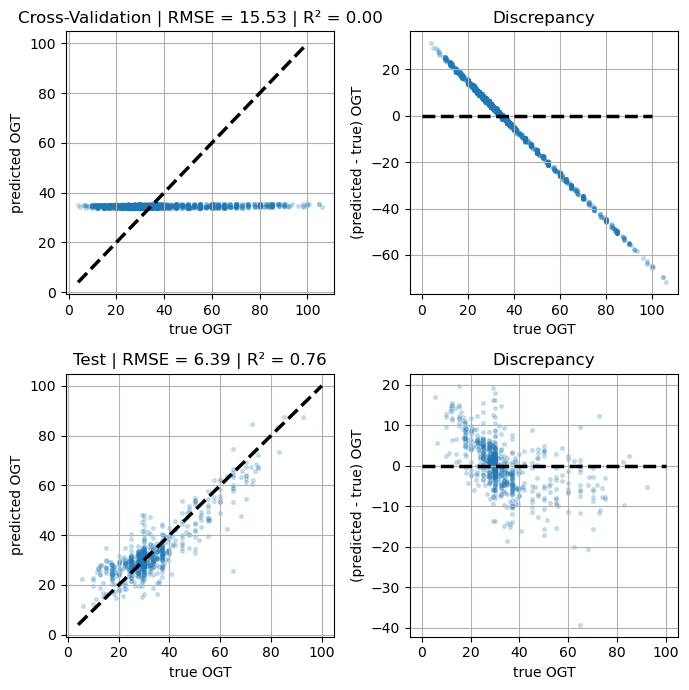

In [47]:
plt.figure(figsize=(7, 7))

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

plt.subplot(2, 2, 3) 
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 4) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy")
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

### 2. Feature selection

#### 2.1. Feature space

In [ ]:
X_train_np = np.array(X_train)
X_train_transposed = X_train_np.T
print(f"X_train_transposed shape = {X_train_transposed.shape}")

Next, we perform feature selection. First, we rank all the features with respect to the chosen method (mutual information, random forest weigths, and SHAP) from the most to the least importan ones. Then we gradually add ranked features starting from the most important one, re-train the model and evaluate its performance. As the second test, we gradually remove features satrting from the least important ones, and evaluate the performance of the re-trained model again. The results are shown below.

As a baseline, we do this analysis for random feature ranking, i.e. we generate random feature order N times, and find the average accuracy and std across the runs for the added and removed features.

In [ ]:
from utils.utils import random_feat_removal_curves_ogt
num_runs = 5
feat_step = 20

feat_removal = False
rmse_test_arr_mean_add, rmse_test_arr_std_add, r2_test_arr_mean_add, r2_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)

In [ ]:
feat_removal = True
rmse_test_arr_mean_rem, rmse_test_arr_std_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem  = random_feat_removal_curves_ogt(X_train, X_test, y_train, y_test, num_runs, feat_step, feat_removal)

#### 3.1 Feature selection with Mutual Information

In this section, we rank the features (COGs) using the mutual information. The mutual information quantifies "the amount of information one random variable contains about another".

We calculate the mutual information between each feature and the target label vector with phenotypes, and rank all the features from the largest to the smallest value.

In [11]:
from feature_selection.feature_selection_utils import mutual_info_features

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train, y_train.squeeze(), X_column_names, RANDOM_SEED, contin_flag = True)

In [12]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(len(top_feat_mi_counts[0]))

print(f"Top {N} COGs:", top_N_names_by_mi)

2276
Top 30 COGs: ['K03296', 'K03286', 'K06158', 'K07277', 'K02199', 'K09458', 'K03654', 'K08234', 'K00537', 'K03088', 'K03559', 'K15977', 'K03832', 'K10804', 'K00831', 'K03321', 'K07305', 'K01142', 'K07735', 'K05807', 'K03797', 'K06911', 'K12340', 'K09808', 'K03704', 'K01256', 'K04744', 'K02078', 'K07107', 'K02355']


Using the ranked features, we re-generate the PCA and tSNE projections using the top N features only. It's expected that the separation between diffetent classes become more prominent.

Shape of the projected data = (2276, 2)


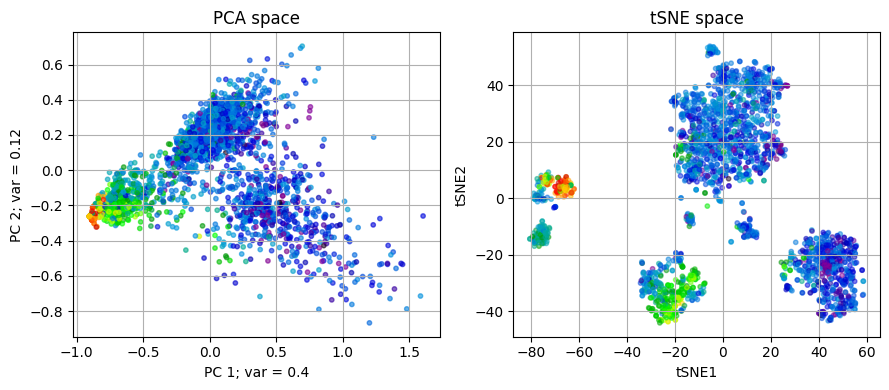

In [13]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_mi_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_mi_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_top{N}_mi_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_mi_add, r2_test_arr_mi_add, rmse_cv_arr_mi_add, r2_cv_arr_mi_add, num_feat_plot = xgboost_accuracy_contin(X_train.cpu(), X_test.cpu(), y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_mi_add, rmse_cv_arr_mi_add, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_mi_add, r2_cv_arr_mi_add, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top MI features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_mi_rem, r2_test_arr_mi_rem, rmse_cv_arr_mi_rem, r2_cv_arr_mi_rem, num_feat_plot_rem = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_mi, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_mi_rem, rmse_cv_arr_mi_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_mi_rem, r2_cv_arr_mi_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top MI features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_mi_feat_remov.pdf", format="pdf") 


#### 3.2 Feature selection with Random Forest

In this section, we rank the features (COGs) using random forest model. During training, the model assigns weights to each feature with respect to their importamce to the prediction task. We train random forest on the train dataset, find the weights, and rank the features with respect to the values of the weights.

The rest of the analysis is the same as the one for the mutual information.

In [ ]:
from feature_selection.feature_selection_utils import random_forest_features

sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_train, y_train, X_column_names, RANDOM_SEED, contin_flag = True)

In [ ]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

In [ ]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_forest_counts).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_forest_counts).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_randfor_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_randfor, r2_test_arr_randfor, rmse_cv_arr_randfor, r2_cv_arr_randfor, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_randfor, rmse_cv_arr_randfor, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_randfor, r2_cv_arr_randfor, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top RandomForest features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_forest_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_randfor_rem, r2_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, r2_cv_arr_randfor_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_rand_forest, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_randfor_rem, rmse_cv_arr_randfor_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_randfor_rem, r2_cv_arr_randfor_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top RandomForest features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_rand_forest_feat_remov.pdf", format="pdf") 

#### 3.3 Feature selection with SHAP values

In this section, we rank the features (COGs) with respect to their SHAP values. SHAP value for a feature is calculated by re-training a model without this feature and comparing the accuracy to the original one on the full feature set. We calculate SHAP values for all features, and rank them from the largest to the smallest.

The rest of the analysis is the same as the ones in the two previous cases.

In [ ]:
from feature_selection.feature_selection_utils import shap_features

contin_flag = True
sorted_cog_idx_by_shap, sorted_importances, sorted_names = shap_features(X_train, y_train, X_column_names, DEVICE, contin_flag)

In [ ]:
# Select the top N features
N = 30
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_rand_shap = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]
print(f"Top {N} COGs:", top_N_names_by_shap)

In [ ]:
from utils.utils import pca_run_and_plot, tsne_plot

plt.figure(figsize=(9, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(np.array(top_feat_rand_shap).T, n_compon, y_train);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(np.array(top_feat_rand_shap).T, 50, 100, RANDOM_SEED, y_train);

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tse_top{N}_shap_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import xgboost_accuracy_contin   

feat_step = 20
feat_removal = False
rmse_test_arr_shap, r2_test_arr_shap, rmse_cv_arr_shap, r2_cv_arr_shap, num_feat_plot   = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_shap, rmse_cv_arr_shap, rmse_test_arr_mean_add, rmse_test_arr_std_add, rmse_cv_arr_mean_add, rmse_cv_arr_std_add, num_feat_plot)
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features added")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_shap, r2_cv_arr_shap, r2_test_arr_mean_add, r2_test_arr_std_add, r2_cv_arr_mean_add, r2_cv_arr_std_add, num_feat_plot)
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features added")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for adding top SHAP features") 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_add.pdf", format="pdf") 

In [ ]:
feat_removal = True
rmse_test_arr_shap_rem, r2_test_arr_shap_rem, rmse_cv_arr_shap_rem, r2_cv_arr_shap_rem, num_feat_plot_rem  = xgboost_accuracy_contin(X_train, X_test, y_train, y_test, sorted_cog_idx_by_shap, feat_step, feat_removal)

In [ ]:
from feature_selection.feature_selection_utils import plot_accuracy_metric

fig = plt.figure(figsize=(8, 8))
tot_num_feat = X_train.cpu().shape[1]

plt.subplot(2,1, 1)
plot_accuracy_metric(rmse_test, rmse_cv, rmse_test_arr_shap_rem, rmse_cv_arr_shap_rem, rmse_test_arr_mean_rem, rmse_test_arr_std_rem, rmse_cv_arr_mean_rem, rmse_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("RMSE")
plt.title("RMSE")
plt.xlabel("number of features kept after removing")

plt.subplot(2,1, 2)
plot_accuracy_metric(r2_test, r2_cv, r2_test_arr_shap_rem, r2_cv_arr_shap_rem, r2_test_arr_mean_rem, r2_test_arr_std_rem, r2_cv_arr_mean_rem, r2_cv_arr_std_rem, [tot_num_feat - n  for n in num_feat_plot])
plt.ylabel("R²")
plt.title("R²")
plt.xlabel("number of features kept after removing")

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1)) 
plt.suptitle("XGBoost accuracy for removing top SHAP features") 
plt.subplots_adjust(hspace=0.4) 
plt.subplots_adjust(hspace=0.4) 
plt.savefig(f"{OUTPUT_DIRECTORY}/accuracy_shap_feat_remov.pdf", format="pdf") 

#### 4. Feature comparison

In this section, we compare top of the most important features predicted with mutual information, random forest, and SHAP values between each other. The lists of the top N features should overlap..

In [ ]:
import pandas as pd

# Define the data for the columns
data = {
    'MI': top_N_names_by_mi,
    'RandomForest': top_N_names_by_rand_forest,
    'SHAP': top_N_names_by_shap
}

# Create DataFrame with specified column names
df = pd.DataFrame(data)

# Print the DataFrame
display(df)

Also, we construct a correlation matrix wetween the top features returned by each method.

In [ ]:
plt.figure(figsize=(15, 3))

vmin, vmax = -1, 1 #-0.6
device = DEVICE
# Correlation matrix for MI top features
plt.subplot(1, 3, 1) 
correlation_matrix = np.corrcoef(top_feat_mi_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("MI top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_mi)), labels=top_N_names_by_mi)
plt.colorbar()

# Correlation matrix for RANDOM Forest top features
plt.subplot(1, 3, 2) 
correlation_matrix = np.corrcoef(top_feat_rand_forest_counts)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("RandomForest top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_rand_forest)), labels=top_N_names_by_rand_forest)
plt.colorbar()

# Correlation matrix for SHAP top features
plt.subplot(1, 3, 3) 
correlation_matrix = np.corrcoef(top_feat_rand_shap)
plt.imshow(correlation_matrix, vmin=vmin, vmax=vmax, cmap="PiYG")
plt.title("SHAP top features", fontsize=10)
plt.xticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap, rotation=90, ha="right")
plt.yticks(ticks=np.arange(len(top_N_names_by_shap)), labels=top_N_names_by_shap)
plt.colorbar()
plt.savefig(f"{OUTPUT_DIRECTORY}/correlat_matr_top{N}_feat.pdf", format="pdf")

#### 5. Expression level of the top features

In this section, we visualize the expression level of a feature in the train samples (with respect to the feature counts). Comparison of this plot to the PCA/tSNE projections with points colored with respect to their phenotype can give insights on the feature "signal distribution" across the samples and the different phenotype groups.

In [ ]:
feature_name = 'K10804'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_val_train[:, idx]
feature_expression = feature_expression.cpu()

In [ ]:
from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
category_names = ["anaerobe" if yi == 0 else "aerobe" for yi in y_label_train]
pca_run_and_plot(X_val_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_val_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

# Display the plots
plt.tight_layout()  
plt.savefig(f"{OUTPUT_DIRECTORY}/pca_tsne_{feature_name}_express_lev.pdf", format="pdf")
plt.show()

In [ ]:
# Number of selected features to add/remove from the list of top features
N = 3000
ogt_continuous_flag = True
precence_only_flag = False

plt.figure(figsize=(12.5, 12.5))

# MI top features signal
select_feat_mi = list(sorted_cog_idx_by_mi[:N])
X_train_select_feat = X_train[:, select_feat_mi]
X_test_select_feat = X_test[:, select_feat_mi]

select_feat_mi_rem = list(sorted_cog_idx_by_mi[N:])
X_train_select_feat_rem = X_train[:, select_feat_mi_rem]
X_test_select_feat_rem = X_test[:, select_feat_mi_rem]

# 1: MI top N predict
plt.subplot(4, 4, 1) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 5: Diff for MI top N predict
plt.subplot(4, 4, 5) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 9: MI top N predict: test
plt.subplot(4, 4, 9) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 13: Diff for MI top N predict
plt.subplot(4, 4, 13) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 2: MI w/o top N predict
plt.subplot(4, 4, 2) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o top {N}, CV | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 6: Diff for MI w/o top N predict
plt.subplot(4, 4, 6) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 10: MI w/o N predict: test
plt.subplot(4, 4, 10) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"MI w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 14: Diff for MI top N predict
plt.subplot(4, 4, 14) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "tab:blue", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# RandomForest only signal
select_feat_ranfor = list(sorted_cog_idx_by_rand_forest[:N])
X_train_select_feat = X_train[:, select_feat_ranfor]
X_test_select_feat = X_test[:, select_feat_ranfor]

select_feat_ranfor_rem = list(sorted_cog_idx_by_rand_forest[N:])
X_train_select_feat_rem = X_train[:, select_feat_ranfor_rem]
X_test_select_feat_rem = X_test[:, select_feat_ranfor_rem]

#3: RandomForest top N predict
plt.subplot(4, 4, 3) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat.cpu(), y_train, X_test_select_feat.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#7: Diff RandomForest top N predict
plt.subplot(4, 4, 7) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 11: RandomForest top N predict: test
plt.subplot(4, 4, 11) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor top {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 15: Diff for RandomForest top N predict
plt.subplot(4, 4, 15) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

#4: RandomForest w/o top N predict
plt.subplot(4, 4, 4) 
y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train_select_feat_rem.cpu(), y_train, X_test_select_feat_rem.cpu(), y_test)
rmse = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2 = r2_score(y_true_cv, y_pred_cv)
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o top {N}, CV| RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

#8: Diff RandomForest w/o top N predict
plt.subplot(4, 4, 8) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# 12: RandomForest top N predict: test
plt.subplot(4, 4, 12) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)
plt.scatter(y_test, y_pred_test, marker='o', alpha = 0.2, c = "darkgreen", s=7)
plt.plot([4,100],[4,100], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"RandFor w/o {N}, test | RMSE={rmse:.2f} | R²={r2:.2f}", fontsize= 10)
plt.grid(True)

# 16: Diff for RandomForest w/o top N predict
plt.subplot(4, 4, 16) 
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_test))]
plt.scatter(y_test, diff, marker='^', alpha = 0.2, c = "darkgreen", s=7, facecolor='none')    
plt.plot([0,100],[0,0], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title("Discrepancy", fontsize= 10)
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

num_coinc = len(set(select_feat_mi) & set(select_feat_ranfor))
print(f"Number of coinciding COGs =  {num_coinc}, which is {round(100*num_coinc/N,2)}%")

plt.savefig(f"{OUTPUT_DIRECTORY}/examples_top{N}_feat.pdf", format="pdf")